# Book Name Extraction Project

**By Jai K. Smith (Jai.K.Smith.22@dartmouth.edu)**  
**Computational Linguistics - Spring 2021**

### Clone Repository

In [ ]:
!rm -rf *
!git clone https://github.com/jaismith/book-name-extraction
!mv book-name-extraction/** .
!rm -rf book-name-extraction main.ipynb

Cloning into 'book-name-extraction'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 69 (delta 25), reused 57 (delta 13), pack-reused 0
Unpacking objects: 100% (69/69), done.


# Creating Model

In [ ]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

import json
import os
import shutil
from bs4 import BeautifulSoup
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
from requests import get
import csv
from datetime import datetime
import random
import json
import re
import numpy as np

import matplotlib.pyplot as plt

import constants
from modules import loader, preprocessing

## Load timetable textbook fields

In [ ]:
text_data = json.loads(open('data/raw/source.json', 'r').read())

data = []
for snippet in text_data:
  soup = BeautifulSoup(snippet, 'html.parser')
  segments = filter(
    lambda s:
      not s.startswith('Textbook information not yet submitted by department/program for ') and
      not s.startswith('Textbook(s) Required for '),
    soup.get_text(separator='<<AND>>', strip=True).split('<<AND>>')
  )

  data += list(preprocessing.standardize(segment) for segment in segments)

data = preprocessing.rule_based_clumping(data)

## Download ORC data

In [ ]:
if not os.path.isfile('data/raw/orc.json'):
    loader.fetch_source(constants.DATA_SOURCE, 'orc.json')

## Prepare dataset for training

Before running this step, please create the `data/processed` folder containing `positive/` and `negative/` subfolders.

In [ ]:
# clear and recreate processed dir (empty)
if os.path.isdir('data/processed'):
    shutil.rmtree('data/processed', ignore_errors=True)
os.makedirs('data/processed/train/positive')
os.mkdir('data/processed/train/negative')
os.makedirs('data/processed/test/positive')
os.mkdir('data/processed/test/negative')

# generate dataset
preprocessing.generate_positive()
preprocessing.generate_negative()

Generated 11707 positive samples
Generated 11707 negative samples


## Configure tf dataset

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

# training set
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'data/processed/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# validation set
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'data/processed/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# testing set
test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'data/processed/test',
    batch_size=batch_size
)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 19900 files belonging to 2 classes.
Using 15920 files for training.
Found 19900 files belonging to 2 classes.
Using 3980 files for validation.
Found 3514 files belonging to 2 classes.


## Select BERT model

[see options here](https://www.tensorflow.org/text/tutorials/classify_text_with_bert#choose_a_bert_model_to_fine-tune)

In [ ]:
# # use ALBERT
# tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/albert_en_base/2'
# tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/albert_en_preprocess/3'

# use small bert
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

## Define model

Based off binary text classification example [here](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

## Define loss function

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

## Define optimizer

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

## Load BERT

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

## Train

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
498/498 [==============================] - 122s 229ms/step - loss: 0.1111 - binary_accuracy: 0.9564 - val_loss: 0.0271 - val_binary_accuracy: 0.9915
Epoch 2/5
498/498 [==============================] - 111s 222ms/step - loss: 0.0169 - binary_accuracy: 0.9950 - val_loss: 0.0216 - val_binary_accuracy: 0.9955
Epoch 3/5
498/498 [==============================] - 112s 224ms/step - loss: 0.0079 - binary_accuracy: 0.9977 - val_loss: 0.0222 - val_binary_accuracy: 0.9957
Epoch 4/5
498/498 [==============================] - 112s 226ms/step - loss: 0.0047 - binary_accuracy: 0.9987 - val_loss: 0.0232 - val_binary_accuracy: 0.9955
Epoch 5/5
498/498 [==============================] - 112s 226ms/step - loss: 0.0031 - binary_accuracy: 0.9991 - val_loss: 0.0251 - val_binary_accuracy: 0.9955


## Test

In [13]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

110/110 [==============================] - 11s 98ms/step - loss: 0.0302 - binary_accuracy: 0.9946
Loss: 0.030168350785970688
Accuracy: 0.99459308385849


## Training stats

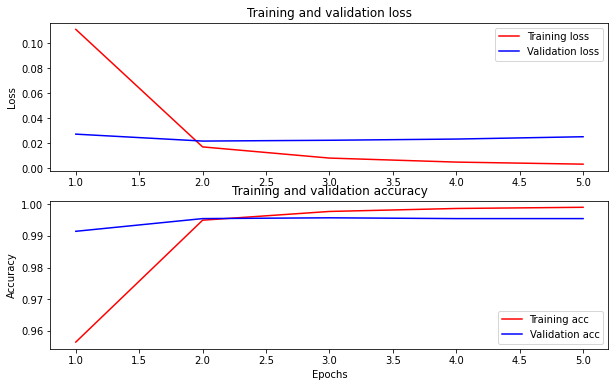

In [14]:
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Export

This will export the model to `classifier.zip`, which can be downloaded.

In [15]:
dataset_name = 'textbook_name_recognition'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

!zip -r /content/classifier.zip /content/textbook_name_recognition_bert
!rm -rf /content/textbook_name_recognition_bert

INFO:tensorflow:Assets written to: ./textbook_name_recognition_bert/assets


INFO:tensorflow:Assets written to: ./textbook_name_recognition_bert/assets


  adding: content/textbook_name_recognition_bert/ (stored 0%)
  adding: content/textbook_name_recognition_bert/assets/ (stored 0%)
  adding: content/textbook_name_recognition_bert/assets/vocab.txt (deflated 53%)
  adding: content/textbook_name_recognition_bert/variables/ (stored 0%)
  adding: content/textbook_name_recognition_bert/variables/variables.index (deflated 75%)
  adding: content/textbook_name_recognition_bert/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/textbook_name_recognition_bert/saved_model.pb (deflated 92%)
  adding: content/textbook_name_recognition_bert/keras_metadata.pb (deflated 84%)


## Sample usage

In [16]:
def print_examples(inputs, results):
  for i in range(len(inputs)):
    print('input: {}\n\tscore: {:.3f}%'.format(inputs[i], results[i][0] * 100))

examples = [
  'harry potter by jk. rowling',
  'Intro to Data Structures, Cormen et. al, 2020',
  'You will be required to purchase these textbooks',
  'required readings:',
  'harry potter, 339 pages',
  'What is gender',
  'Al-kitaab fii Ta\'allum al-\'Arabiyya, with DVDs, a Textbook for Intermediate Arabic, Part two, third Edition Georgetown University Press, Washington',
  'intro to gender studies',
  'intro to chemistry',
  'Embodied psychologies'
]

results = tf.sigmoid(classifier_model(tf.constant(list(preprocessing.standardize(example) for example in examples))))

print_examples(examples, results)

input: harry potter by jk. rowling
	score: 99.998%
input: Intro to Data Structures, Cormen et. al, 2020
	score: 98.616%
input: You will be required to purchase these textbooks
	score: 0.001%
input: required readings:
	score: 0.001%
input: harry potter, 339 pages
	score: 99.982%
input: What is gender
	score: 0.002%
input: Al-kitaab fii Ta'allum al-'Arabiyya, with DVDs, a Textbook for Intermediate Arabic, Part two, third Edition Georgetown University Press, Washington
	score: 99.986%
input: intro to gender studies
	score: 0.405%
input: intro to chemistry
	score: 0.036%
input: Embodied psychologies
	score: 0.005%


# Classifying Timetable Segments

## Test on manually tagged data

In [17]:
# True - BOOK, False - NOT BOOK, None - MERGED INTO NEXT (interpret as BOOK)
manual_labels = [True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, True, False, True, True, True, True, False, True, True, True, False, False, False, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, False, True, False, True, False, True, True, False, True, False, True, True, True, True, True, True, True, True, False, True, True, False, True, True, False, True, True, False, True, True, True, True, True, False, True, True, True, False, True, True, False, False, True, True, False, False, False, False, False, False, True, True, True, False, False, False, False, True, True, True, False, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, False, False, False, False, False, True, False, False, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, True, False, True, True, True, False, True, True, True, False, False, True, True, True, False, True, True, True, False, False, True, False, True, False, False, True, False, True, True, True, False, True, True, True, False, False, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, True, True, True, True, True, False, False, True, True, True, True, True, False, True, True, True, True, True, False, False, True, True, False, False, False, True, True, True, True, True, True, True, False, True, False, False, True, False, True, True, True, True, True, False, True, True, True, False, True, True, False, False, True, False, True, False, False, False, False, False, True, True, True, False, False, False, True, True, True, True, False, False, False, False, True, True, False, False, True, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, True, True, True, False, False, True, False, False, True, True, True, False, False, False, True, False, False, True, False, True, True, True, True, False, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, False, False, True, False, False, True, False, True, True, True, True, True, False, True, False, False, True, True, True, True, True, True, True, False, True, False, True, True, True, True, True, False, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, False, False, False, True, False, True, False, False, True, True, True, False, False, False, True, True, True, True, True, False, True, False, True, False, True, False, False, True, False, True, False, True, False, True, False, False, False, True, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, True, False, True, True, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, False, True, False, True, True, True, True, True, False, True, False, True, False, True, False, True, True, False, False, True, False, True, False, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, False, True, True, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, True, True, True, False, False, True, True, False, True, True, True, False, False, False, True, True, False, True, True, True, True, False, True, True, True, False, True, True, True, False, True, False, False, False, False, True, True, False, True, False, False, True, True, True, True, False, True, True, True, True, True, False, True, True, True, True, True, True]

scores = tf.sigmoid(classifier_model(tf.constant(data[:len(manual_labels)])))
computed_labels = list(score[0] > 0.5 for score in scores)

tp, fp, tn, fn = 0, 0, 0, 0
for i in range(len(manual_labels)):
  err = False

  if computed_labels[i]:
    if manual_labels[i]: tp += 1
    else:
      fp += 1
      err = True
  else:
    if manual_labels[i]:
      fn += 1
      err = True
    else: tn += 1

  if err: print('"{}"\n\tincorrectly classified: {} ({}%)'.format(data[i], 'BOOK' if computed_labels[i] else 'NOT BOOK', scores[i][0] * 100))

print('\nConfusion Matrix:\n\tTP: {:<3d}\tFP: {:<3d}\n\tFN: {:<3d}\tTN: {:<3d}'.format(tp, fp, fn, tn))
print('\nPrecision: {:.3f}\nRecall: {:.3f}'.format(tp / (tp + fp), tp / (tp + fn)))

"Fadiman, Anne"
	incorrectly classified: BOOK (99.35369110107422%)
"None. Readings available in Canvas."
	incorrectly classified: BOOK (99.24520874023438%)
"0 9 8 7 6 5 4 3 2 1 2004"
	incorrectly classified: BOOK (99.97216796875%)
"Amazon New $154.66  Used $121.96 Rent $ 76.97 91520"
	incorrectly classified: NOT BOOK (0.7209190726280212%)
"Reading and video materials will be provided via Canvas and 2hr Dana library Loan."
	incorrectly classified: NOT BOOK (0.007098568137735128%)
"The older 7th edition is adequate, and you may be able to find a used copy for sale."
	incorrectly classified: NOT BOOK (0.008042467758059502%)
"For the 8th edition, only two purchase options are available."
	incorrectly classified: NOT BOOK (0.013738580979406834%)
"32 pages"
	incorrectly classified: BOOK (68.25786590576172%)
"32 pages"
	incorrectly classified: BOOK (68.25786590576172%)
"Required Zubrick, James W. The Organic Chem Lab Survival Manual, A Students Guide to Techniques, 10th ed., John Wiley and So